In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import subprocess

import cftime

import dask
from dask.diagnostics import ProgressBar

import xarray as xr
import numpy as np
import pandas as pd

import pop_tools

from obdaac_download import httpdl
import util

USER = os.environ['USER']

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [4]:
clobber = False
dst_grid = 'POP_gx1v6'
FILE_OUT = f'{util.project_tmpdir}/seawifs_mapped_monthly_chl_gsm_DJF.{dst_grid}.zarr'
FILE_OUT    

'/glade/p/cgd/oce/projects/krill-cesm-le/data/seawifs_mapped_monthly_chl_gsm_DJF.POP_gx1v6.zarr'

In [5]:
server = 'oceandata.sci.gsfc.nasa.gov'
localpath = f'/glade/work/{USER}/seawifs/chl_gsm/Monthly'

df = pd.read_csv('seawifs_mapped_monthly_chl_gsm.filelist', delim_whitespace=True)
filelist = df.filename.to_list()
print(f'{len(filelist)} files')
print(f'{filelist[0]} ... {filelist[-1]}')

delayed_obj = []
for f in filelist:
    if not os.path.exists(f'{localpath}/{f}'):
        request = f'/ob/getfile/{f}'
        delayed_obj.append(dask.delayed(httpdl)(server, request, uncompress=True, localpath=localpath))

if delayed_obj:
    print(f'downloading {len(delayed_obj)} files')
    with ProgressBar():
        dask.compute(*delayed_obj)
else:
    print('all files present on disk')

156 files
S19972441997273.L3m_MO_GSM_chl_gsm_9km.nc ... S20103352010365.L3m_MO_GSM_chl_gsm_9km.nc
all files present on disk


In [6]:
gridfile_directory = f'{util.project_tmpdir}/regrid'
os.makedirs(gridfile_directory, exist_ok=True)

In [7]:
src_grid = 'latlon_9km_lon180'
src_grid_file = f'{gridfile_directory}/{src_grid}.nc'

if not os.path.exists(src_grid_file) or clobber:
    dso = util.latlon_to_scrip(
        nx=4320, 
        ny=2160, 
        lon0=-180., 
        file_out=src_grid_file,
    )

In [8]:
dst_grid_file= f'{gridfile_directory}/{dst_grid}.nc'

if not os.path.exists(dst_grid_file) or clobber:
    dso = pop_tools.get_grid('POP_gx1v6', scrip=True)
    del dso.attrs['region_mask_regions']
    print(f'writing {dst_grid_file}')
    dso.to_netcdf(dst_grid_file)

In [9]:
%%time
method = 'conserve'
weight_file = f'{gridfile_directory}/{src_grid}_to_{dst_grid}_{method}.nc'

if not os.path.exists(weight_file) or clobber:
    cmd = ['ESMF_RegridWeightGen', '--netcdf4', '--ignore_unmapped',
                '-s', src_grid_file, '-d', dst_grid_file, '-m', method, '-w', weight_file]
    out = subprocess.run(cmd, capture_output=True, check=True)
    print(out.stdout.decode('UTF-8'))

CPU times: user 193 µs, sys: 96 µs, total: 289 µs
Wall time: 757 µs


In [10]:
regrid_op = util.regridder(src_grid_file, dst_grid_file, weight_file)
regrid_op

source grid dims: (2160, 4320)
destination grid dims: (384, 320)


regridder latlon_9km_lon180.nc --> POP_gx1v6.nc

In [11]:
pop_grid = pop_tools.get_grid('POP_gx1v6')[['TLAT', 'TLONG', 'KMT', 'TAREA']]
pop_grid

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320)
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    KMT      (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    TAREA    (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
Attributes:
    lateral_dims:         [384, 320]
    vertical_dims:        60
    vert_grid_file:       gx1v7_vert_grid
    horiz_grid_fname:     inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ie...
    topography_fname:     inputdata/ocn/pop/gx1v6/grid/topography_20090204.ie...
    region_mask_fname:    inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.i...
    type:                 dipole
    region_mask_regions:  {'Caspian Sea': -14, 'Black Sea': -13, 'Baltic Sea'...
    title:                POP_gx1v6 grid

In [40]:
time_units = 'days since 1970-01-01 00:00:00'

def regrid_chl(chl_src):
    """apply valid_min and valid_max and regrid"""    
    chl_src = chl_src.where(
        (chl_src.valid_min <= chl_src) & (chl_src <= chl_src.valid_max)
    )
    return regrid_op.regrid_dataarray(
        chl_src[::-1, :],
        renormalize=True,
        apply_mask=False,
    )

@dask.delayed
def file_regrid_chl(file_in, file_out):
    """read chlorophyll file, interpret time, regrid and write to file"""
    ds_src = xr.open_dataset(file_in)
    
    # process time
    year_start = int(ds_src.time_coverage_start[:4])
    month_start = int(ds_src.time_coverage_start[5:7])
    day_start = int(ds_src.time_coverage_start[8:10])

    year_end = int(ds_src.time_coverage_end[:4])
    month_end = int(ds_src.time_coverage_end[5:7])
    day_end = int(ds_src.time_coverage_end[8:10])

    time_bnds = [cftime.datetime(year_start, month_start, day_start), cftime.datetime(year_end, month_end, day_end)]
    time_bnds = cftime.date2num(time_bnds, units=time_units)
    time_bnds[1] = time_bnds[1] + 1
    
    time = xr.DataArray(
        [np.mean(time_bnds)], 
        dims=('time'),
        attrs={'long_name': 'time', 'units': time_units, 'bounds': 'time_bounds'},
        name='time',
    )

    time_bnds = xr.DataArray(
        [time_bnds], 
        dims=('time', 'd2'),
        attrs={'long_name': 'time bounds'},
        name='time_bounds',
        coords={'time': time}
    )

    
    # regrid data
    chl_src = ds_src.chl_gsm
    chl_dst = regrid_chl(chl_src).expand_dims(time=time)
    
    
    dso = xr.Dataset({
        'time': time, 
        'time_bounds': time_bnds,
        'chl_gsm': chl_dst,
    })
    dso.to_netcdf(file_out)

    return dso
    
localpath_out = f'{localpath}/{dst_grid}'
os.makedirs(localpath_out, exist_ok=True)

delayed_obj = []
dst_filelist = []
for f in filelist:
    file_in = f'{localpath}/{f}'
    file_out = f'{localpath_out}/{f.replace(".nc", f"_{dst_grid}.nc")}'
    dst_filelist.append(file_out)
    if not os.path.exists(file_out) or clobber:
        delayed_obj.append(file_regrid_chl(file_in, file_out))
    
if delayed_obj:
    with ProgressBar():
        ds_list = dask.compute(*delayed_obj)

dst_filelist

['/glade/work/mclong/seawifs/chl_gsm/Monthly/POP_gx1v6/S19972441997273.L3m_MO_GSM_chl_gsm_9km_POP_gx1v6.nc',
 '/glade/work/mclong/seawifs/chl_gsm/Monthly/POP_gx1v6/S19972741997304.L3m_MO_GSM_chl_gsm_9km_POP_gx1v6.nc',
 '/glade/work/mclong/seawifs/chl_gsm/Monthly/POP_gx1v6/S19973051997334.L3m_MO_GSM_chl_gsm_9km_POP_gx1v6.nc',
 '/glade/work/mclong/seawifs/chl_gsm/Monthly/POP_gx1v6/S19973351997365.L3m_MO_GSM_chl_gsm_9km_POP_gx1v6.nc',
 '/glade/work/mclong/seawifs/chl_gsm/Monthly/POP_gx1v6/S19980011998031.L3m_MO_GSM_chl_gsm_9km_POP_gx1v6.nc',
 '/glade/work/mclong/seawifs/chl_gsm/Monthly/POP_gx1v6/S19980321998059.L3m_MO_GSM_chl_gsm_9km_POP_gx1v6.nc',
 '/glade/work/mclong/seawifs/chl_gsm/Monthly/POP_gx1v6/S19980601998090.L3m_MO_GSM_chl_gsm_9km_POP_gx1v6.nc',
 '/glade/work/mclong/seawifs/chl_gsm/Monthly/POP_gx1v6/S19980911998120.L3m_MO_GSM_chl_gsm_9km_POP_gx1v6.nc',
 '/glade/work/mclong/seawifs/chl_gsm/Monthly/POP_gx1v6/S19981211998151.L3m_MO_GSM_chl_gsm_9km_POP_gx1v6.nc',
 '/glade/work/mclon

In [43]:
%%time
ds = xr.open_mfdataset(dst_filelist, combine='by_coords', decode_times=False)
ds = ds.set_coords(ds.time.bounds)
time_bnds = ds[ds.time.bounds]
ds = xr.decode_cf(ds.drop(ds.time.bounds), decode_times=True, use_cftime=True)
ds['time_bnds'] = time_bnds.assign_coords(time=ds.time)

pop_grid = pop_tools.get_grid('POP_gx1v6')[['TLAT', 'TLONG', 'KMT', 'TAREA']]
ds = xr.merge((ds, pop_grid))
ds

CPU times: user 774 ms, sys: 111 ms, total: 886 ms
Wall time: 6.12 s


,Array,Chunk
Bytes,2.50 kB,16 B
Shape,"(156, 2)","(1, 2)"
Count,468 Tasks,156 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,153.35 MB,983.04 kB
Shape,"(156, 384, 320)","(1, 384, 320)"
Count,468 Tasks,156 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [44]:
ds_djf = util.ann_mean(ds, season='DJF')
util.write_ds_out(ds_djf, FILE_OUT)

------------------------------
Writing /glade/p/cgd/oce/projects/krill-cesm-le/data/seawifs_mapped_monthly_chl_gsm_DJF.POP_gx1v6.zarr
xarray.Dataset {
dimensions:
	lat = 384 ;
	lon = 320 ;
	nlat = 384 ;
	nlon = 320 ;
	time = 12 ;

variables:
	float64 chl_gsm(time, lat, lon) ;
		chl_gsm:long_name = Chlorophyll Concentration, GSM model ;
		chl_gsm:units = mg m^-3 ;
		chl_gsm:standard_name = mass_concentration_chlorophyll_concentration_in_sea_water ;
		chl_gsm:valid_min = 0.0010000000474974513 ;
		chl_gsm:valid_max = 100.0 ;
		chl_gsm:reference = Maritorena S., D.A. Siegel and A. Peterson, Optimization of a Semi-Analytical Ocean Color Model for Global Scale Applications, Applied  Optics,  41(15): 2705-2714, 2002. ;
		chl_gsm:display_scale = log ;
		chl_gsm:display_min = 0.009999999776482582 ;
		chl_gsm:display_max = 20.0 ;
	float64 TLAT(time, nlat, nlon) ;
		TLAT:units = degrees_north ;
		TLAT:long_name = T-grid latitude ;
	float64 TLONG(time, nlat, nlon) ;
		TLONG:units = degrees_east ;


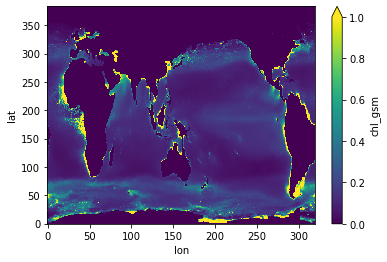

In [45]:
ds_djf.chl_gsm.mean('time').plot(vmin=0, vmax=1.)

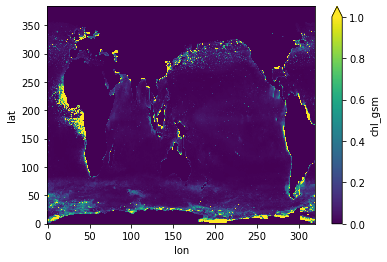

In [46]:
ds_djf.chl_gsm.std('time').plot(vmin=0, vmax=1.)